In [1]:
import numpy as np
import itertools
import os
import pandas as pd
import seaborn as sea

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE

import xgboost as xgb
from xgboost import plot_importance

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
sea.set_style("darkgrid")

In [4]:
data = pd.read_csv("/content/diabetes.csv")

data.head(10).style.set_precision(2). \
                    set_properties(**{"min-width": "60px"}). \
                    set_properties(**{"color": "#111111"}). \
                    set_properties(**{"text-align": "center"}). \
                    set_table_styles([
                          {"selector": "th",
                           "props": [("font-weight", "bold"),
                                     ("font-size", "12px"),
                                     ("text-align", "center")]},
                          {"selector": "tr:nth-child(even)",
                           "props": [("background-color", "#f2f2f2")]},
                          {"selector": "tr:nth-child(odd)",
                           "props": [("background-color", "#fdfdfd")]},
                          {"selector": "tr:hover",
                           "props": [("background-color", "#bcbcbc")]}])

<ipython-input-4-9dc2bf5b67c5>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  data.head(10).style.set_precision(2). \


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1
5,5,116,74,0,0,25.60,0.20,30,0
6,3,78,50,32,88,31.00,0.25,26,1
7,10,115,0,0,0,35.30,0.13,29,0
8,2,197,70,45,543,30.50,0.16,53,1
9,8,125,96,0,0,0.00,0.23,54,1


In [5]:
pd.options.mode.chained_assignment = None

data_X = data.loc[:, data.columns != "Outcome"]
data_Y = data[["Outcome"]]

print("data_X info:\n")
data_X.info()
print("\ndata_Y info:\n")
data_Y.info()

data_X info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB

data_Y info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Outcome  768 non-null    int64
dtypes: int64(1)
memory usage: 6.1 KB


In [6]:
data_Y["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

# Split Data

In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y,
                                                    test_size=0.2,
                                                    stratify=data_Y,
                                                    random_state=0)

train_X.reset_index(drop=True, inplace=True);
test_X.reset_index(drop=True, inplace=True);
train_Y.reset_index(drop=True, inplace=True);
test_Y.reset_index(drop=True, inplace=True);

# Visualization and checking for outliers

In [8]:
def plots(feature):
    fig = plt.figure(constrained_layout = True, figsize=(10,3))
    gs = gridspec.GridSpec(nrows=1, ncols=4, figure=fig)

    ax1 = fig.add_subplot(gs[0,:3])    
    sea.distplot(train_X.loc[train_Y["Outcome"]==0,feature],
                 kde = False, color = "#004a4d", norm_hist=False,
                 hist_kws = dict(alpha=0.8), bins=40,
                 label="Not Diabetes", ax=ax1);
    sea.distplot(train_X.loc[train_Y["Outcome"]==1,feature],
                 kde = False, color = "#7d0101", norm_hist=False,
                 hist_kws = dict(alpha=0.6), bins=40,
                 label="Diabetes", ax=ax1);
    ax2 = fig.add_subplot(gs[0,3])    
    sea.boxplot(train_X[feature], orient="v", color = "#989100",
                width = 0.2, ax=ax2);
    
    ax1.legend(loc="upper right");

# Feature 0 : Pregnancies

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


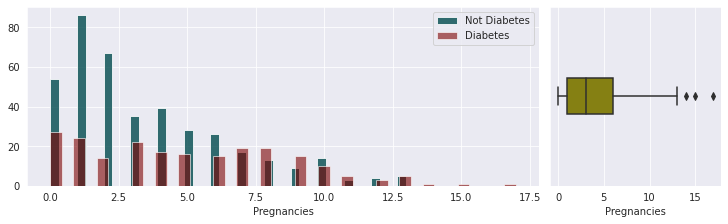

In [10]:
plots("Pregnancies")

In [11]:
Q1 = train_X["Pregnancies"].quantile(0.25)
Q3 = train_X["Pregnancies"].quantile(0.75)
q95th = train_X["Pregnancies"].quantile(0.95)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Pregnancies"] = np.where(train_X["Pregnancies"] > UW,
                                  q95th, train_X["Pregnancies"])

# Feature 1 : Glucose

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


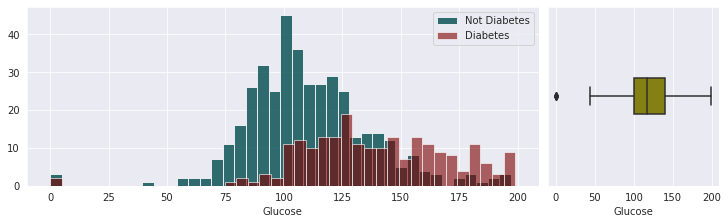

In [12]:
plots("Glucose")

In [13]:
med = train_X["Glucose"].median()
train_X["Glucose"] = np.where(train_X["Glucose"] == 0, med, train_X["Glucose"])

# Feature 2 : Blood Pressure

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


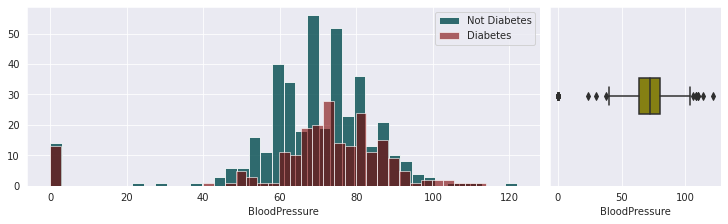

In [14]:
plots("BloodPressure")

In [15]:
med = train_X["BloodPressure"].median()
q5th = train_X["BloodPressure"].quantile(0.05)
q95th = train_X["BloodPressure"].quantile(0.95)
Q1 = train_X["BloodPressure"].quantile(0.25)
Q3 = train_X["BloodPressure"].quantile(0.75)
IQR = Q3 - Q1
LW = Q1 - 1.5*IQR
UW = Q3 + 1.5*IQR

train_X["BloodPressure"] = np.where(train_X["BloodPressure"] == 0,
                                    med, train_X["BloodPressure"])
train_X["BloodPressure"] = np.where(train_X["BloodPressure"] < LW,
                                    q5th, train_X["BloodPressure"])
train_X["BloodPressure"] = np.where(train_X["BloodPressure"] > UW,
                                    q95th, train_X["BloodPressure"])

# Feature 3 : Skin Thickness

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


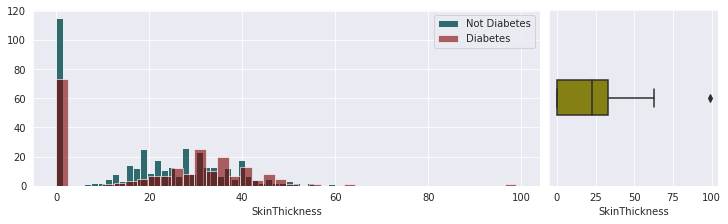

In [16]:
plots("SkinThickness")

In [17]:
med = train_X["SkinThickness"].median()
q95th = train_X["SkinThickness"].quantile(0.95)
Q1 = train_X["SkinThickness"].quantile(0.25)
Q3 = train_X["SkinThickness"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["SkinThickness"] = np.where(train_X["SkinThickness"] == 0,
                                    med, train_X["SkinThickness"])
train_X["SkinThickness"] = np.where(train_X["SkinThickness"] > UW,
                                    q95th, train_X["SkinThickness"])

# Feature 4 : Insulin

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


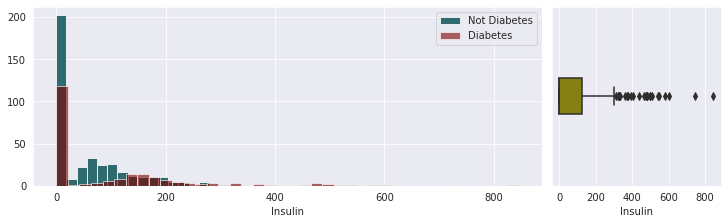

In [18]:
plots("Insulin")

In [19]:
q60th = train_X["Insulin"].quantile(0.60)
q95th = train_X["Insulin"].quantile(0.95)
Q1 = train_X["Insulin"].quantile(0.25)
Q3 = train_X["Insulin"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Insulin"] = np.where(train_X["Insulin"] == 0,
                              q60th, train_X["Insulin"])
train_X["Insulin"] = np.where(train_X["Insulin"] > UW,
                              q95th, train_X["Insulin"])

# Feature 5 : BMI

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


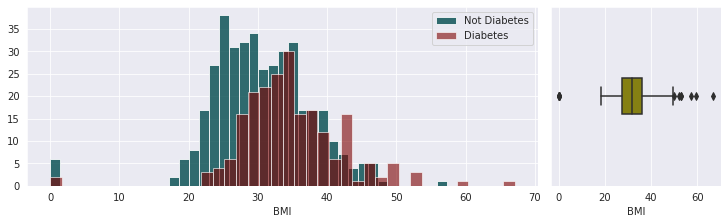

In [20]:
plots("BMI")

In [21]:
med = train_X["BMI"].median()
q95th = train_X["BMI"].quantile(0.95)
Q1 = train_X["BMI"].quantile(0.25)
Q3 = train_X["BMI"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["BMI"] = np.where(train_X["BMI"] == 0,
                          med, train_X["BMI"])
train_X["BMI"] = np.where(train_X["BMI"] > UW,
                          q95th, train_X["BMI"])

# Feature 6 : Daibetes Pedigree Function

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


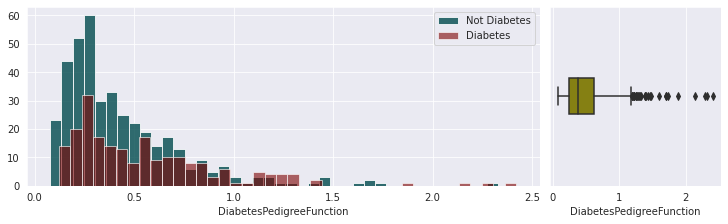

In [22]:
plots("DiabetesPedigreeFunction")

In [23]:
q95th = train_X["DiabetesPedigreeFunction"].quantile(0.95)
Q1 = train_X["DiabetesPedigreeFunction"].quantile(0.25)
Q3 = train_X["DiabetesPedigreeFunction"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["DiabetesPedigreeFunction"] = np.where(
                        train_X["DiabetesPedigreeFunction"] > UW,
                        q95th, train_X["DiabetesPedigreeFunction"])

# Feature 7 : Age

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


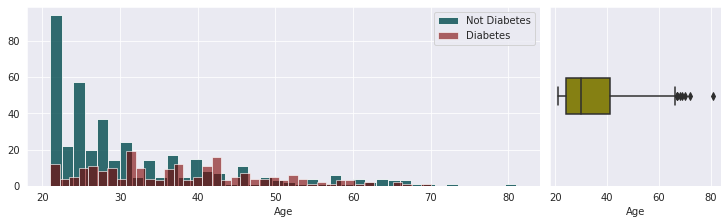

In [24]:
plots("Age")

In [25]:
q95th = train_X["Age"].quantile(0.95)
Q1 = train_X["Age"].quantile(0.25)
Q3 = train_X["Age"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Age"] = np.where(train_X["Age"] > UW,
                          q95th, train_X["Age"])

# Standardization

In [26]:
feature_names = train_X.columns

scaler = StandardScaler()

# fit to train_X
scaler.fit(train_X)

# transform train_X
train_X = scaler.transform(train_X)
train_X = pd.DataFrame(train_X, columns = feature_names)

# transform test_X
test_X = scaler.transform(test_X)
test_X = pd.DataFrame(test_X, columns = feature_names)

# Correlation Analysis

<ipython-input-27-f19a24d61cbe>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))


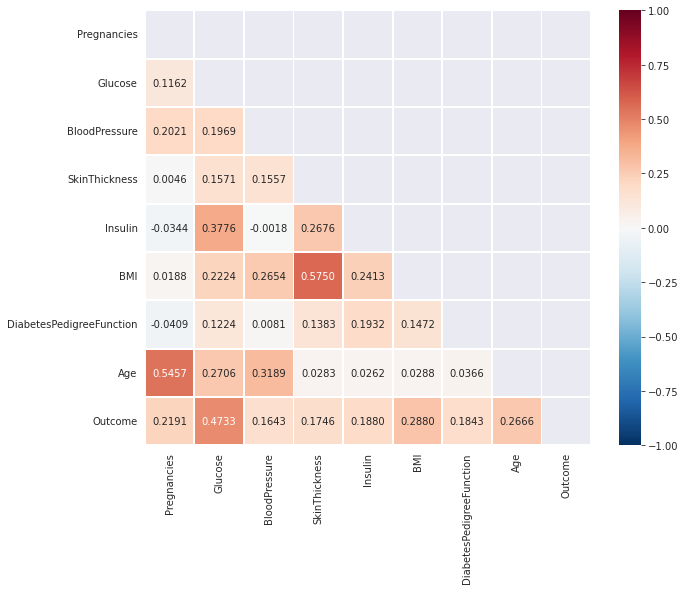

In [27]:
corr_matrix = pd.concat([train_X, train_Y], axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

plt.figure(figsize=(10,8))
sea.heatmap(corr_matrix,annot=True, fmt=".4f",
            vmin=-1, vmax=1, linewidth = 1,
            center=0, mask=mask,cmap="RdBu_r");

# Feature Importance

In [28]:
# logistic regression with l1 penalty - embedded method
lr1 = LogisticRegression(random_state=0, penalty="l1",
            class_weight="balanced", solver="saga", max_iter=5000)
lr1.fit(train_X, train_Y.values.ravel())

lr1.coef_

array([[ 3.60358322e-01,  1.06754141e+00, -2.50971359e-02,
        -9.81326043e-05, -6.49737080e-02,  5.74505582e-01,
         3.35113887e-01,  2.71385240e-01]])

In [29]:
# logistic regression with l2 penalty - embedded method
lr2 = LogisticRegression(random_state=0, penalty="l2",
            class_weight="balanced", solver="saga", max_iter=5000)
lr2.fit(train_X, train_Y.values.ravel())

lr2.coef_

array([[ 0.36506112,  1.07199682, -0.04073014, -0.01616834, -0.07560637,
         0.59537491,  0.34399744,  0.28125417]])

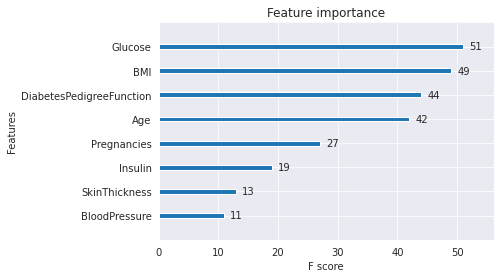

In [30]:
gb = xgb.XGBClassifier(booster="gbtree",
                      learning_rate=0.15,
                      max_depth=4,
                      n_estimators=20,
                      random_state=0)
gb.fit(train_X, train_Y.values.ravel())

plot_importance(gb);

In [31]:
lr3 = LogisticRegression(random_state=0, penalty="l2",
            class_weight="balanced", solver="saga", max_iter=5000)
rfe_lr3 = RFE(lr3, n_features_to_select=7)
rfe_lr3.fit(train_X, train_Y.values.ravel())

print(rfe_lr3.support_)

[ True  True  True False  True  True  True  True]


In [32]:
train_X.drop("SkinThickness", axis=1, inplace=True)
test_X.drop("SkinThickness", axis=1, inplace=True)

# Train Model

In [33]:
clf = MLPClassifier(solver="adam", max_iter=5000, activation = "relu",
                    hidden_layer_sizes = (12),                      
                    alpha = 0.01,
                    batch_size = 64,
                    learning_rate_init = 0.001,
                    random_state=2)

clf.fit(train_X, train_Y.values.ravel());

# Test Model

In [34]:
print(classification_report(test_Y, clf.predict(test_X),
                            digits = 4,
                            target_names=["Not Diabetes",
                                          "Diabetes"]))

              precision    recall  f1-score   support

Not Diabetes     0.8624    0.9400    0.8995       100
    Diabetes     0.8667    0.7222    0.7879        54

    accuracy                         0.8636       154
   macro avg     0.8645    0.8311    0.8437       154
weighted avg     0.8639    0.8636    0.8604       154

